In [1]:
!pip install pycocotools
!pip install mrcnn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373765 sha256=621f0cd059cc3630436775e540754caa4a5aded8985fcfb8887937bf4c2e3c2b
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54932 sha256=a650c3641b7cc340c5cb81d3dc76df861cab994a6ae6120fa89cddd37937bac7
  Stored in directory: /root/.cache/pip/wheels/1d/94/0d/03ff96abc43d2d6c8299a92cbb4eced2a1eda3ca7911c19427
Successfully built mrcnn


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2
import torch
import os
import sys
from torch import nn, Tensor
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import mrcnn
from torchvision.ops import box_convert

In [3]:
print(torch.cuda.is_available())

True


In [4]:
class LiveCellDataset(torch.utils.data.Dataset): #torch.utils.data.Dataset
    def __init__(self, root, annotation_file_path):
        self.root = root
        self.coco_annotation = COCO(annotation_file=annotation_file_path)
        self.image_ids = list(self.coco_annotation.imgs.keys())
        self.images = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy',allow_pickle=True).astype(np.int16)
        self.masks = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy',allow_pickle=True).astype(np.int16)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = self.images[img_id]
        img = img.transpose(2, 0, 1)
        
        ann_ids = self.coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
        anns = self.coco_annotation.loadAnns(ann_ids)
        if (anns != []):
            target = self.get_target(anns, img_id)
    
            img = torch.from_numpy(img)
            img = img/255
            return img, target


    def get_target(self, annotations, idx):
        boxes = []
        labels = []
        area = []
        iscrowd = []
        mask = []
        
        
        image_id = torch.tensor([idx], dtype=torch.int64)
        
        for annotation in annotations:
            cat_id = annotation['category_id']
            labels.append(cat_id)
            
            bounding_box = annotation['bbox']
            boxes.append(bounding_box)
            
            _iscrowd = annotation['iscrowd']
            iscrowd.append(_iscrowd)
            
            _area = annotation['area']
            area.append(_area)
            
            this_mask = np.dstack(self.masks[idx,:,:,cat_id])
            mask.append(this_mask)
        mask = torch.as_tensor(np.copy(mask), dtype=torch.uint8)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.float64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.uint8)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        
        assert len(boxes) == len(iscrowd) == len(labels) == len(area)
        if not (len(boxes) == len(iscrowd) == len(labels) == len(area)):
            print(len(boxes), len(iscrowd), len(labels), len(area))
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return target

    def __len__(self):
        return len(self.image_ids)


In [5]:
#Step 1 & 2
def get_model_instance_segmentation(num_classes):
    # Load the pre-trained model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    return model


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset_train = LiveCellDataset("LiveCellDataset",  
                                '/kaggle/input/finaltraintest/train-pan-nuclei-cancer.json')

dataset_loader_train = torch.utils.data.DataLoader(
dataset_train, batch_size=6, shuffle=True, num_workers=2, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
torch.cuda.empty_cache()

In [9]:
model = get_model_instance_segmentation(6)
model.to(device)


# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [24]:
def train_model(model, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        model.train()

        for images, targets in dataset_loader_train:
            images= list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step()

        
    return model

In [25]:
img,trg = dataset_train.__getitem__(0)

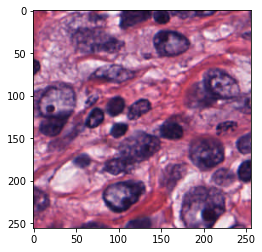

In [19]:
img_arr = np.array(img.cpu())
img_tr = img_arr.transpose(1,2,0)
img_tr = img_tr * 255
plt.imshow(img_tr.astype(int))

In [20]:
display_boxes = np.array(trg['boxes'].cpu().detach())
display_masks = np.array(trg['masks'].cpu().detach())
display_masks = display_masks.transpose(1,3,2,0)[0]
display_labels = np.array(trg['labels'].cpu().detach())

In [26]:
nuclei_names = ["neoplastic","inflammatory","softtissue","dead","epithelial"]

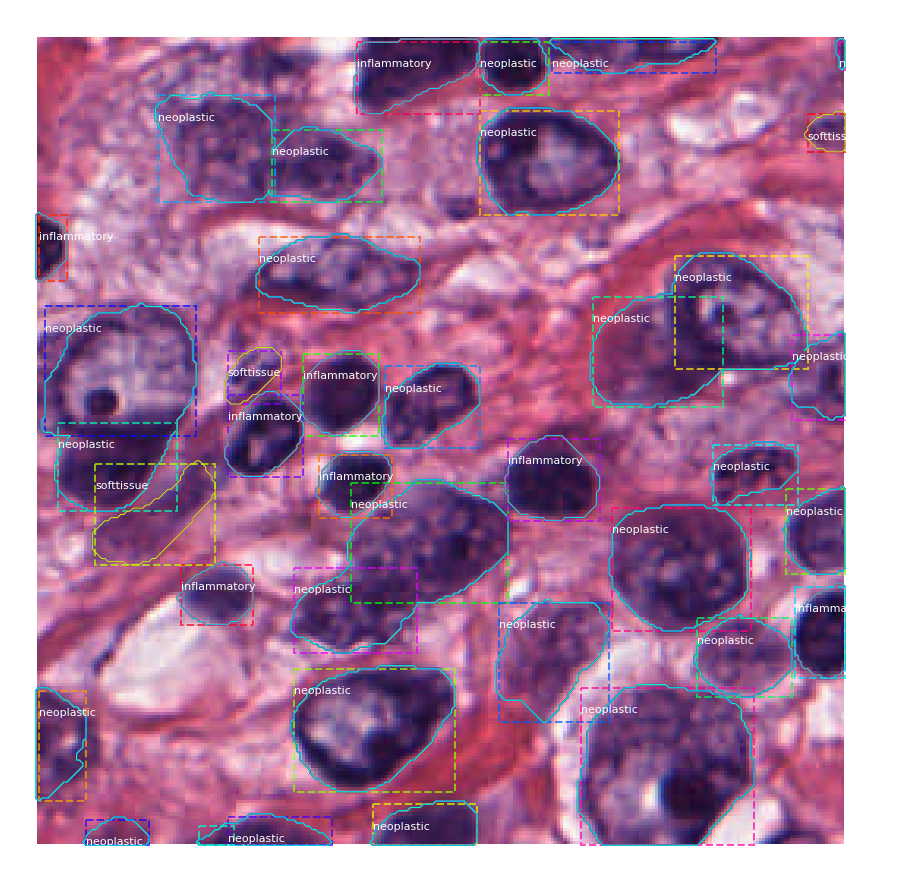

In [27]:
import mrcnn.visualize
mrcnn.visualize.display_instances(img_tr.astype(int), display_boxes.astype(int), display_masks, display_labels, nuclei_names)

In [28]:
model_trained = train_model(model, optimizer, num_epochs=1)

Epoch 1/1
----------


In [29]:
torch.save(model_trained, "myModel.pth")